# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import BernoulliNB, GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier, MLPRegressor
# from sklearn.svm import SVC
# from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [3]:
import pandas_profiling

In [4]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

In [5]:
import seaborn as sns

In [6]:
from xgboost import XGBClassifier

In [6]:
import shap

In [7]:
from collections import Counter

# Function(Utility)

In [8]:
# check Duplicate file
def checkDuplicateFile(file_path):
    import os
    if os.path.isfile(file_path):
        print("Caution: File existed!")
        ans = input("Do you want to cover it?(Y/others)")
        if ans == "Y":
            return False
        else:
            print("Canceled....")
            return True
    else:
        return False

# Function(Use)

In [9]:
# Test for checking ICU_id missing in Lab_1103_csv
def getMissingIDinLab(Lab_file, show=True):
    test = sorted(Lab_file.ICU_id.unique())
    s = 0
    error_list = list()
    for i in test:
        #         print(i)
        s += 1
        if s != i:
            if show:
                print(f"error! : {s}")
            error_list.append(s)
            s += 1
    if show:
        print(f"Missing ID Result: {error_list}")
    if show:
        print(f"Missing Length:{len(error_list)}")
    return error_list

In [10]:
# store Dataframe to CSV
def store2CSV(data, target_name, target_loc_prefix='./'):
    file_path = target_loc_prefix+target_name+".csv"
    if checkDuplicateFile(file_path):
        print("store2CSV failed")
        return
    data.to_csv(file_path)
    print("store2CSV Successful!")

In [11]:
# store Datastruc. to pickle
def store2Pickle(data, target_name, target_loc_prefix='./'):
    import pickle
    file_path = target_loc_prefix+target_name+'.pickle'
    if checkDuplicateFile(file_path):
        print("store2Pickle failed")
        return
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print("store2Pickle Successful!")

In [12]:
def readFPickle(target_name, target_loc_prefix='./'):
    import pickle
    file_name = target_loc_prefix+target_name+'.pickle'
    with open(file_name, 'rb') as f:
        temp = pickle.load(f)
    return temp

# Function(Data processing)

In [13]:
#Function: 補值
# 將針對輸入的df_data直接進行inplace插補
# 須確保df_data的缺失值位置有放np.nan
def handleMissing(df_data, df_feature, outFeature=["outcome"], cate_astype = "int"):
    for featureName in df_data.columns:
        if featureName not in outFeature:
            if df_data[featureName].isna().sum() == 0:
                print(f"{featureName}: Not need to fill.")
                continue
            else:
                # 先去看是連續與否 (1代表連續,0代表離散)
                kindValue = df_feature.loc[df_feature["features name"]
                                           == featureName, "kind"].values[0]
                if kindValue == 1:
                    # continuous
                    # mean filling
                    targetMean = df_data[featureName].mean()
                    df_data[featureName].fillna(value=targetMean, inplace=True)
                    print(f"{featureName}: Fill, Continuous.")

                else:
                    # categorical
                    # mode filling
                    targetMode = df_data[featureName].mode()[0]
                    df_data[featureName].fillna(value=targetMode, inplace=True)
                    df_data[featureName] = df_data[featureName].astype(cate_astype)
                    print(f"{featureName}: Fill, Categorical. (astype to {cate_astype})")
            
    print("---handleMissing Finish---")

In [14]:
# plot hist
# filtered_data need to check not have nan
def plotHist(df_data, target, outcome="outcome", bins=20):
    filtered_data = pd.concat([df_data["outcome"], df_data[target]], axis=1)
    filtered_data = filtered_data.dropna()
    print(filtered_data.isna().sum())
    plt.hist(filtered_data.loc[filtered_data[outcome]==0, target], bins=bins, alpha=0.5, label='0')
    plt.hist(filtered_data.loc[filtered_data[outcome]==1, target], bins=bins, alpha=0.5, label='1')
    plt.xlabel(target)
    plt.ylabel('count')
    plt.legend(title=outcome)

In [15]:
# plot countplot
# filtered_data need to check not have nan
def plotCountplot(df_data, target, outcome="outcome"):
    filtered_data = pd.concat([df_data["outcome"], df_data[target]], axis=1)
    filtered_data = filtered_data.dropna()
    print(filtered_data.isna().sum())
    sns.countplot(x=target, hue=outcome, data=filtered_data)

In [16]:
# plot boxplot
# filtered_data need to check not have nan
def plotBoxplot(df_data, target, outcome="outcome"):
    filtered_data = pd.concat([df_data["outcome"], df_data[target]], axis=1)
    filtered_data = filtered_data.dropna()
    print(filtered_data.isna().sum())
    sns.boxplot(x=filtered_data[target], data=filtered_data)

# Load Data

## raw_data （要用的話，記得往後跑Basic cleaning）
- raw_data:原來資料
    - 52159 subjects
    - 68 features

In [1239]:
raw_data = pd.read_csv("data/tr.csv")

In [1240]:
raw_data

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## raw_features

In [1241]:
raw_features = pd.read_csv("data/raw_data_features.csv")

In [1242]:
raw_features

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,NaN
2,SEX,object,0,"(F,M)"
3,LOS,float64,1,NaN
4,Joint,object,0,"(TKA, THA)"
...,...,...,...,...
63,Alcohol Abuse,int64,0,"(0,1)"
64,Drug Abuse,int64,0,"(0,1)"
65,Psychoses,int64,0,"(0,1)"
66,Depression,int64,0,"(0,1)"


In [1243]:
raw_features.className  = raw_features.className.fillna("None")

In [1244]:
raw_features.className.unique()

array(['(0,1)', 'None', '(F,M)', '(TKA, THA)', '(1,2,3,4)',
       '(0,1,2,3,4,5)', '(0,1,2,3)', '(0,1,2)'], dtype=object)

In [1245]:
raw_features

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(F,M)"
3,LOS,float64,1,None
4,Joint,object,0,"(TKA, THA)"
...,...,...,...,...
63,Alcohol Abuse,int64,0,"(0,1)"
64,Drug Abuse,int64,0,"(0,1)"
65,Psychoses,int64,0,"(0,1)"
66,Depression,int64,0,"(0,1)"


# Data Basic Cleaning
- raw_data去除重複列，剩49141

In [1246]:
raw_data

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1247]:
#沒有全為nan的列
raw_data.dropna(how="all")

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1248]:
#沒有全為nan的行
raw_data.dropna(axis=1,how="all")

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1249]:
#有重複列:3018
raw_data = raw_data.drop_duplicates()
raw_data

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1250]:
raw_data.outcome.value_counts()

0    48270
1      871
Name: outcome, dtype: int64

# Test Area

## Convert categorical (String) to one hot
- get_dummies

In [ ]:
a = set(pd.get_dummies(raw_data).columns)

In [ ]:
b = set(raw_data.columns)

In [ ]:
a-b

In [ ]:
b-a

In [ ]:
pd.get_dummies(raw_data)["SEX_M"]

## Drop na

In [ ]:
#只剩下468subjects, 保留68個features（沒改）
raw_data.dropna()

In [ ]:
raw_data.isnull().values.any()

In [ ]:
raw_data.dropna().isna().values.any()

In [ ]:
type(raw_data.isnull().values)

## np array
- any -> or (有True就為True)
- all -> and

In [ ]:
t = np.array([True, True, True])

In [ ]:
t.all()

# Case3

## Data Load

### 先整理目前留下來的data feature
- case1保留下來的，是缺失值不超過50%以上的feature(含0.49)
- 在後面我們會需要重新調整缺失值補值(要先把outlier清掉，再做補值)->不能用case1_train (要用相同方式再製造一份)
- 我們只留feature（case1_feature），資料重新從raw_data(non duplicate)取得
- SEX, Joint要記得處理

In [17]:
case1_feature_from_file = readFPickle("data/case1_feature")
case1_feature_from_file

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


In [18]:
raw_data_from_file = readFPickle("data/raw_data_del_dup_row")
raw_data_from_file

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
case3_feature = case1_feature_from_file.copy()

In [20]:
case3_raw_data = raw_data_from_file.copy()

In [21]:
case3_feature["features name"].to_list()

['outcome',
 'AGE',
 'SEX',
 'LOS',
 'Joint',
 'Drain',
 'Cemented',
 'Commercial_ALBC',
 'Non_commercial_ALBC',
 'cci_index',
 'elx_index',
 'Blood_trans',
 'OP_time_minute',
 'OP_time_hour',
 'ASA',
 'Diagnosis',
 'Congestive Heart Failure',
 'Cardiac Arrhythmia',
 'Valvular Disease',
 'Heart disease',
 'Pulmonary Circulation Disorders',
 'Peripheral Vascular Disorders',
 'Hypertension Uncomplicated',
 'Paralysis',
 'Other Neurological Disorders',
 'Chronic Pulmonary Disease',
 'Lung disease',
 'Diabetes',
 'Hypothyroidism',
 'Renal Failure',
 'Liver Disease',
 'Peptic Ulcer Disease excluding bleeding',
 'AIDS/HIV',
 'Lymphoma',
 'Metastatic Cancer',
 'Solid Tumor without Metastasis',
 'Cancer history',
 'Rheumatoid Arthritis/collagen',
 'Coagulopathy',
 'Obesity',
 'Weight Loss',
 'Fluid and Electrolyte Disorders',
 'Blood Loss Anemia',
 'Deficiency Anemia',
 'Anemia',
 'Alcohol Abuse',
 'Drug Abuse',
 'Psychoses',
 'Depression',
 'Psyciatric disorder']

In [22]:
#篩選成缺失值小於50p以上的
case3_train = case3_raw_data[case3_feature["features name"].to_list()].copy()

In [23]:
case3_train

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
case3_train.isna().sum()

outcome                                        0
AGE                                           67
SEX                                           67
LOS                                           67
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             17161
OP_time_hour                               17161
ASA                                        17213
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

## Data analysis

- 

In [25]:
case3_train.isna().sum()

outcome                                        0
AGE                                           67
SEX                                           67
LOS                                           67
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             17161
OP_time_hour                               17161
ASA                                        17213
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

In [1562]:
# filtered_data.isna().sum()

outcome                                    0
AGE                                        0
SEX                                        0
LOS                                        0
Joint                                      0
Drain                                      0
Cemented                                   0
Commercial_ALBC                            0
Non_commercial_ALBC                        0
cci_index                                  0
elx_index                                  0
Blood_trans                                0
OP_time_minute                             0
OP_time_hour                               0
ASA                                        0
Diagnosis                                  0
Congestive Heart Failure                   0
Cardiac Arrhythmia                         0
Valvular Disease                           0
Heart disease                              0
Pulmonary Circulation Disorders            0
Peripheral Vascular Disorders              0
Hypertensi

In [34]:
%matplotlib inline

### AGE

In [35]:
case3_train[(case3_train["AGE"].isna())&(case3_train["SEX"].isna())&(case3_train["LOS"].isna())].outcome.value_counts()

0    92
1     2
Name: outcome, dtype: int64

outcome    0
AGE        0
dtype: int64


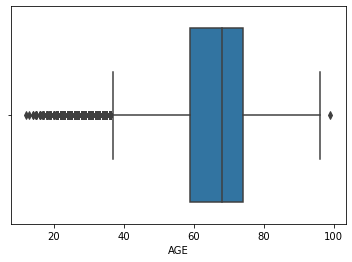

In [36]:
plotBoxplot(case3_train, "AGE")

In [39]:
case3_train[case3_train["AGE"]>96.5]

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
38387,0,99.0,F,6.0,TKA,0,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0


In [42]:
case3_train[case3_train["AGE"]<36.5].outcome.value_counts()

0    1754
1      32
Name: outcome, dtype: int64

In [393]:
filtered_data.loc[filtered_data["AGE"]<39].outcome.value_counts()

0    1300
1      16
Name: outcome, dtype: int64

outcome    0
AGE        0
dtype: int64


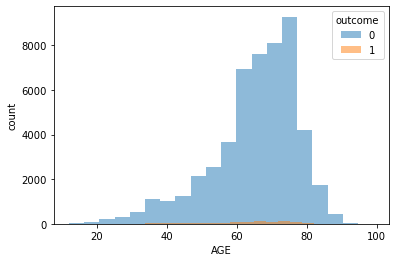

In [508]:
plotHist(case3_train, "AGE")

outcome    0
AGE        0
dtype: int64


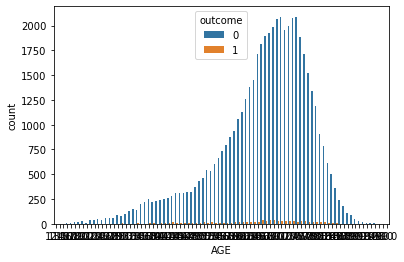

In [517]:
plotCountplot(case3_train, "AGE")

In [404]:
filtered_data["AGE"]

1        69.0
3        66.0
5        84.0
8        81.0
9        56.0
         ... 
52154    78.0
52155    78.0
52156    73.0
52157    74.0
52158    76.0
Name: AGE, Length: 31961, dtype: float64

In [1225]:
case3_train[case3_train["AGE"].isna()].outcome.value_counts()

0    65
1     2
Name: outcome, dtype: int64

### SEX

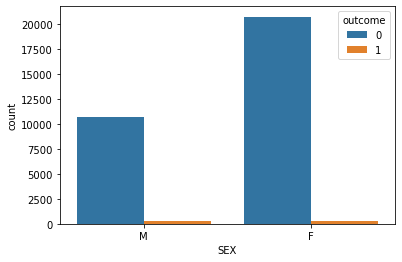

In [408]:
plotCountplot(filtered_data, "SEX")

outcome    0
SEX        0
dtype: int64


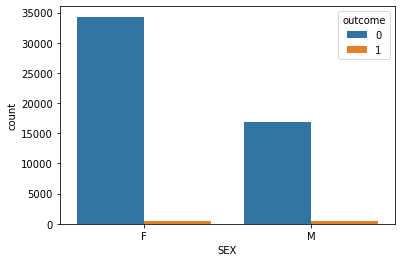

In [518]:
plotCountplot(case3_train, "SEX")

In [414]:
case3_train[case3_train["SEX"].isna()].outcome.value_counts()

0    92
1     2
Name: outcome, dtype: int64

### LOS(Length of stay)
- LOS與outcome似乎有關係

outcome    0
LOS        0
dtype: int64


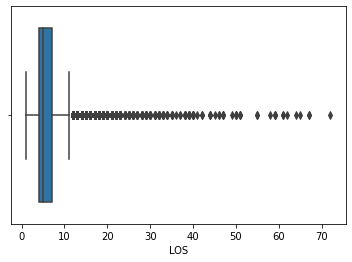

In [521]:
# sns.boxplot(x=filtered_data['LOS'], data=filtered_data)
plotBoxplot(case3_train, "LOS")

In [1227]:
case3_train.loc[case3_train["LOS"]>11.5].outcome.value_counts()

0    1161
1      83
Name: outcome, dtype: int64

outcome    0
LOS        0
dtype: int64


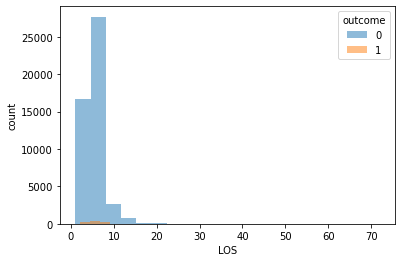

In [1228]:
plotHist(case3_train, "LOS")

### Joint

outcome    0
Joint      0
dtype: int64


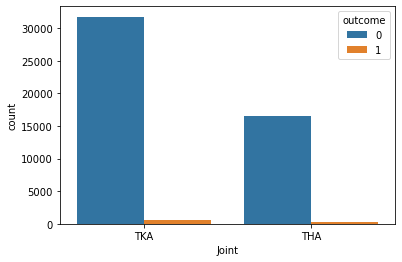

In [1229]:
plotCountplot(case3_train, "Joint")

### Drain

outcome    0
Drain      0
dtype: int64


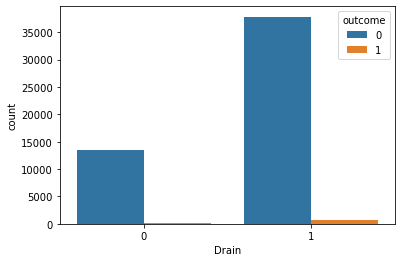

In [527]:
plotCountplot(case3_train, "Drain")

### Cemented

outcome     0
Cemented    0
dtype: int64


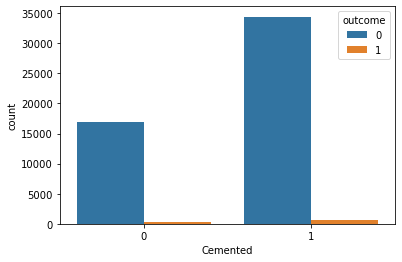

In [528]:
plotCountplot(case3_train, "Cemented")

### **Commercial_ALBC

outcome            0
Commercial_ALBC    0
dtype: int64


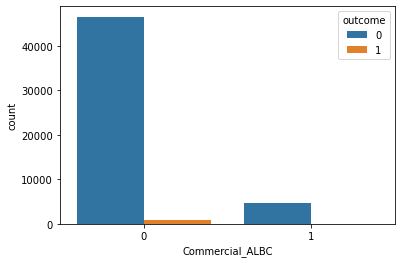

In [529]:
plotCountplot(case3_train, "Commercial_ALBC")

### Non_commercial_ALBC

outcome                0
Non_commercial_ALBC    0
dtype: int64


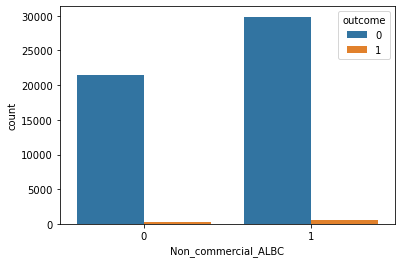

In [530]:
plotCountplot(case3_train, "Non_commercial_ALBC")

In [531]:
#證明兩個變數不是互補的
filt = (case3_train["Commercial_ALBC"]==1) & (case3_train["Non_commercial_ALBC"]==1)
case3_train.loc[filt]

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
111,1,75.0,F,4.0,TKA,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
444,1,55.0,M,8.0,TKA,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
465,1,22.0,M,23.0,TKA,1,1,1,1,8,...,0,0,0,0,0,0,0,0,0,0
537,1,37.0,M,44.0,TKA,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
844,1,57.0,F,5.0,TKA,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51273,0,77.0,F,12.0,TKA,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
51383,0,68.0,F,5.0,TKA,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
51737,0,69.0,F,4.0,TKA,1,1,1,1,2,...,0,1,0,0,0,0,0,0,0,0
51858,0,81.0,F,9.0,TKA,1,1,1,1,2,...,0,1,0,0,0,0,0,0,0,0


### cci_index

outcome      0
cci_index    0
dtype: int64


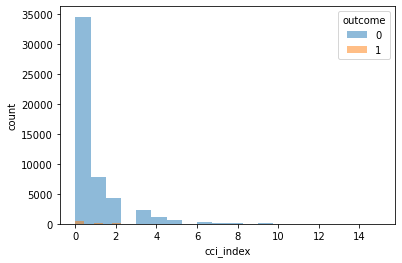

In [532]:
plotHist(case3_train, "cci_index")

outcome      0
cci_index    0
dtype: int64


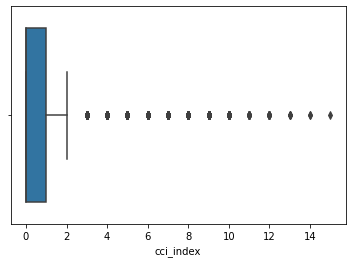

In [533]:
# sns.boxplot(x=filtered_data['cci_index'], data=filtered_data)
plotBoxplot(case3_train, "cci_index")

In [1230]:
case3_train.loc[case3_train["cci_index"]>2].outcome.value_counts()

0    4655
1     132
Name: outcome, dtype: int64

In [1232]:
case3_train.outcome.value_counts()

0    48270
1      871
Name: outcome, dtype: int64

### elx_index

outcome      0
elx_index    0
dtype: int64


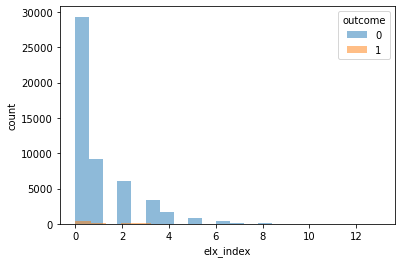

In [536]:
plotHist(case3_train, "elx_index")

outcome      0
elx_index    0
dtype: int64


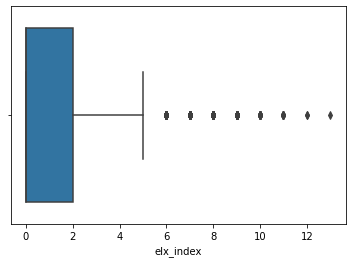

In [537]:
# sns.boxplot(x=filtered_data['elx_index'], data=filtered_data)
plotBoxplot(case3_train, "elx_index")

In [1233]:
case3_train.loc[case3_train["elx_index"]>5].outcome.value_counts()

0    757
1     29
Name: outcome, dtype: int64

### Blood_trans

outcome        0
Blood_trans    0
dtype: int64


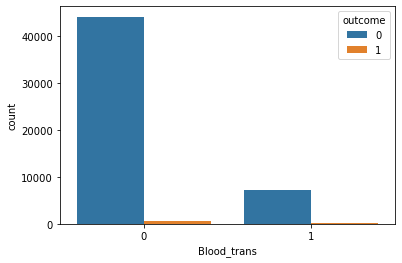

In [539]:
plotCountplot(case3_train, "Blood_trans")

### OP_time_minute

In [540]:
case3_train.loc[case3_train["OP_time_minute"].isna()].outcome.value_counts()

0    19752
1      354
Name: outcome, dtype: int64

In [542]:
#沒有那種有人沒有minute有hour的
raw_data.loc[(raw_data["OP_time_minute"].isna()) & (~raw_data["OP_time_hour"].isna())]

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder


In [453]:
#沒有那種有人有minute沒有hour的
raw_data.loc[(~raw_data["OP_time_minute"].isna()) & (raw_data["OP_time_hour"].isna())]

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder


outcome           0
OP_time_minute    0
dtype: int64


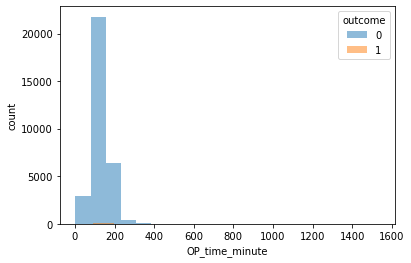

In [543]:
plotHist(case3_train, "OP_time_minute")

outcome           0
OP_time_minute    0
dtype: int64


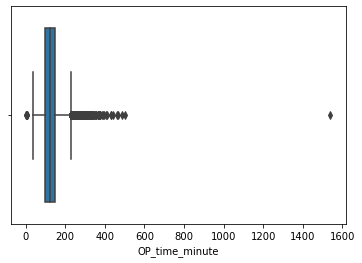

In [544]:
# sns.boxplot(x=filtered_data['OP_time_minute'], data=filtered_data)
plotBoxplot(case3_train, "OP_time_minute")

In [545]:
case3_train.loc[case3_train["OP_time_minute"]>229].outcome.value_counts()

0    473
1     20
Name: outcome, dtype: int64

In [546]:
case3_train.loc[case3_train["OP_time_minute"]<21].outcome.value_counts()

0    5
Name: outcome, dtype: int64

In [823]:
case3_train.OP_time_minute.isna().sum()

20106

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


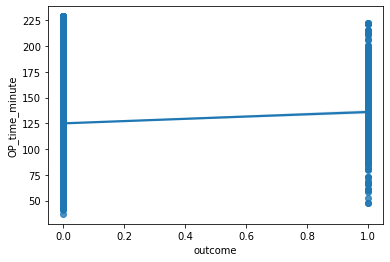

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


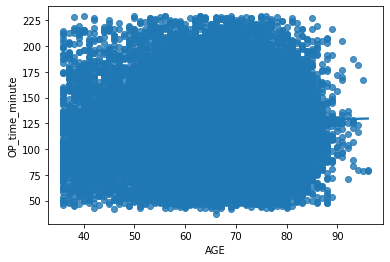

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


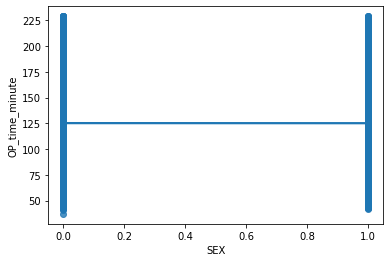

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


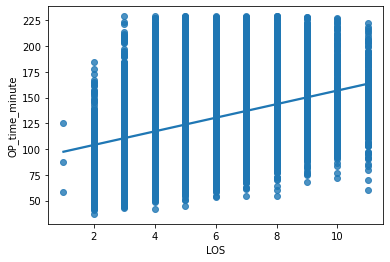

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


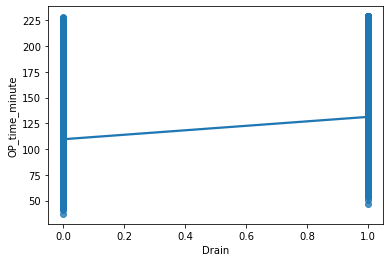

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


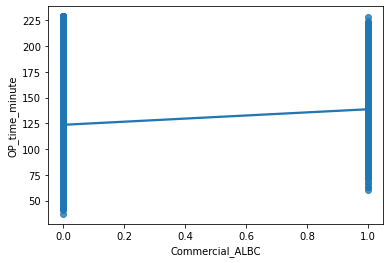

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


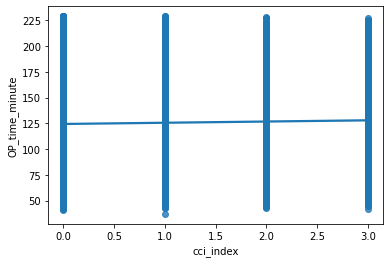

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


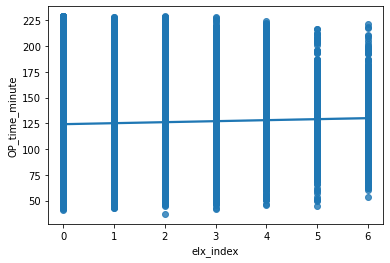

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


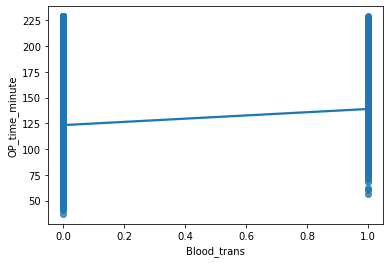

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


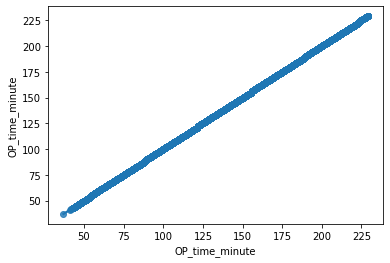

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


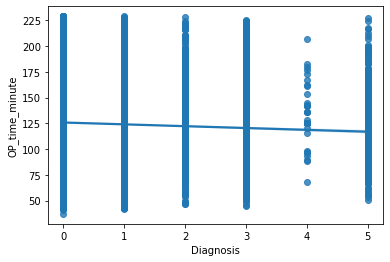

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


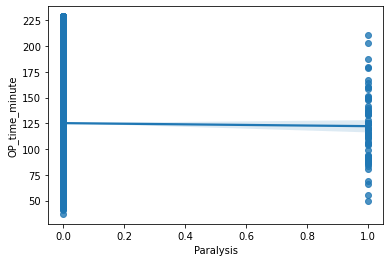

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


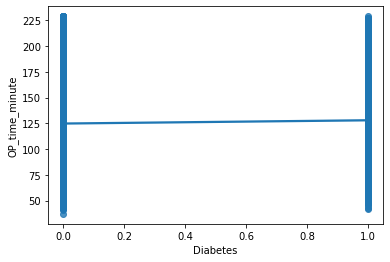

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


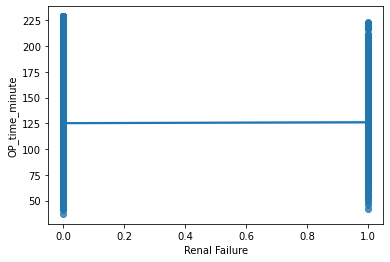

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


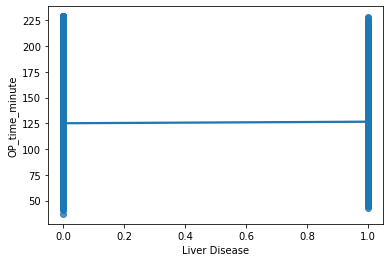

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


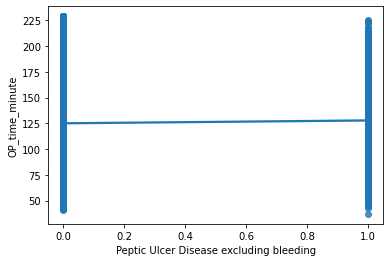

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


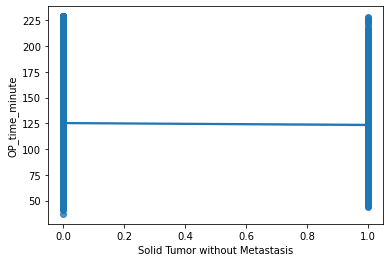

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


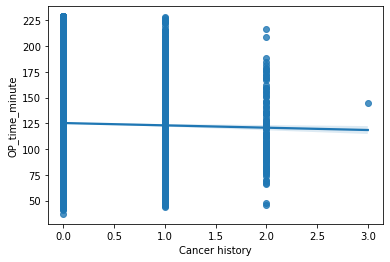

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


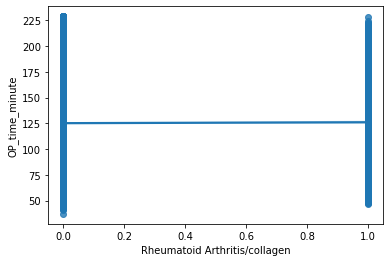

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


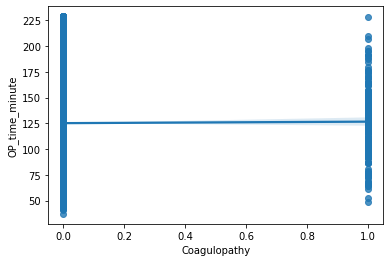

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


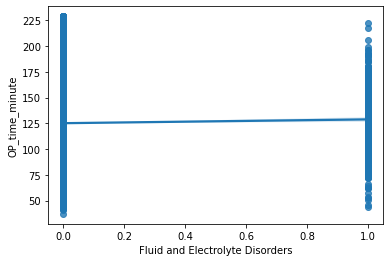

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


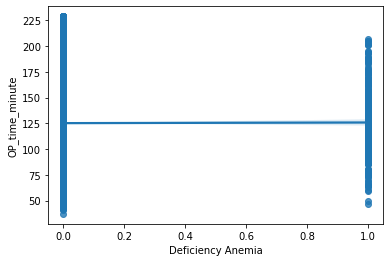

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


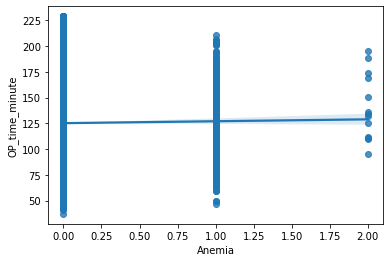

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


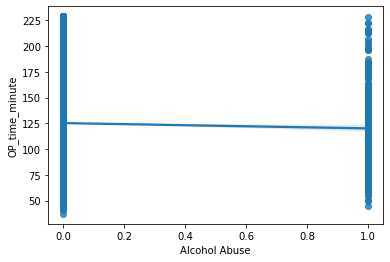

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


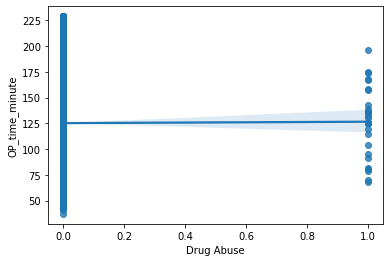

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


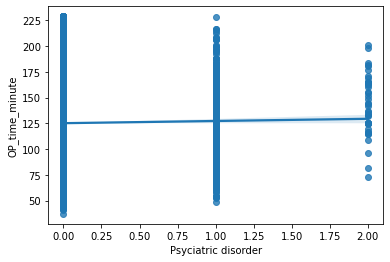

In [469]:
for fea in case3_train_final.columns:
    sns.regplot(fea, "OP_time_minute", data=case3_train_final)
    plt.show()

/home/oscarchencs10/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='LOS', ylabel='OP_time_minute'>

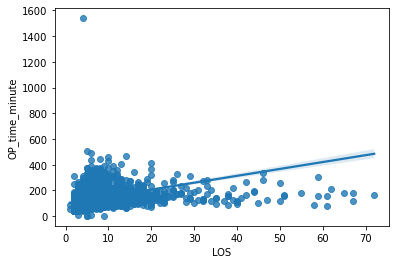

In [470]:
 sns.regplot("LOS", "OP_time_minute", data=raw_data)

### OP_time_hour

In [455]:
raw_data.loc[raw_data["OP_time_hour"].isna()].outcome.value_counts()

0    19752
1      354
Name: outcome, dtype: int64

outcome         0
OP_time_hour    0
dtype: int64


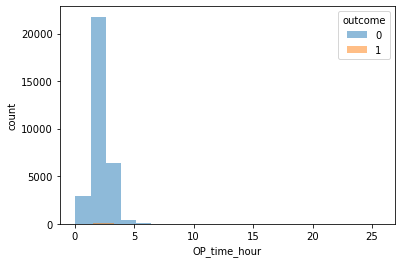

In [547]:
plotHist(case3_train, "OP_time_hour")

outcome         0
OP_time_hour    0
dtype: int64


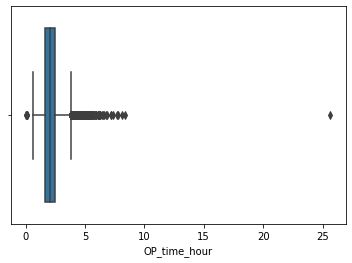

In [548]:
# sns.boxplot(x=filtered_data['OP_time_hour'], data=filtered_data)
plotBoxplot(case3_train, "OP_time_hour")

### ASA

outcome    0
ASA        0
dtype: int64


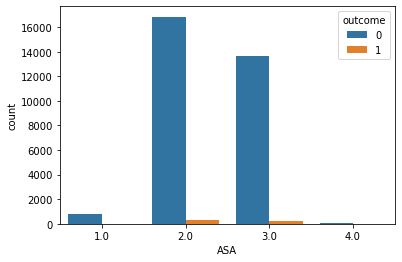

In [1234]:
plotCountplot(case3_train, "ASA")

In [490]:
#可以嘗試拔掉na中outcome是０的，剩下outcome是1的補2
raw_data.loc[raw_data["ASA"].isna()].outcome.value_counts()

0    19803
1      355
Name: outcome, dtype: int64

In [684]:
raw_data.loc[(raw_data["ASA"].isna())&(~raw_data["OP_time_minute"].isna())].outcome.value_counts()

0    51
1     1
Name: outcome, dtype: int64

In [1132]:
raw_data.loc[raw_data["ASA"]==2].outcome.value_counts()

0    16900
1      274
Name: outcome, dtype: int64

In [1133]:
raw_data.loc[raw_data["ASA"]==3].outcome.value_counts()

0    13712
1      235
Name: outcome, dtype: int64

In [ ]:
#"ASA"

### Diagnosis

In [471]:
raw_data.Diagnosis.unique()

array([0, 2, 1, 5, 4, 3])

In [479]:
filtered_data.Diagnosis.unique()

array([0, 1, 4, 3, 2, 5])

outcome      0
Diagnosis    0
dtype: int64


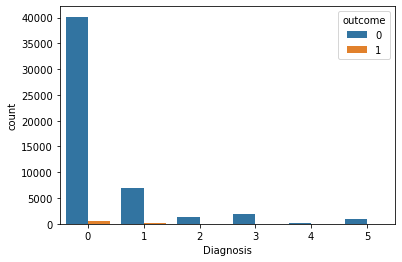

In [550]:
plotCountplot(case3_train, "Diagnosis")

In [566]:
case3_train.loc[case3_train["Diagnosis"]==3].outcome.value_counts()

0    1987
1      51
Name: outcome, dtype: int64

### Congestive Heart Failure

### Heart disease

outcome          0
Heart disease    0
dtype: int64


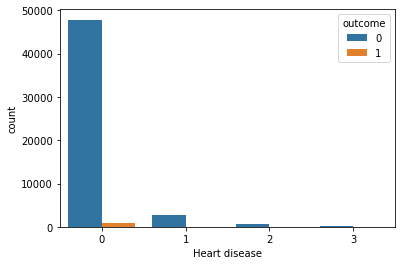

In [568]:
plotCountplot(case3_train, "Heart disease")

In [572]:
case3_train.loc[case3_train["Heart disease"]==0].outcome.value_counts()

0    47869
1      808
Name: outcome, dtype: int64

In [569]:
case3_train.loc[case3_train["Heart disease"]==1].outcome.value_counts()

0    2750
1      52
Name: outcome, dtype: int64

In [570]:
case3_train.loc[case3_train["Heart disease"]==2].outcome.value_counts()

0    576
1     18
Name: outcome, dtype: int64

In [571]:
case3_train.loc[case3_train["Heart disease"]==3].outcome.value_counts()

0    85
1     1
Name: outcome, dtype: int64

### Lung disease

outcome         0
Lung disease    0
dtype: int64


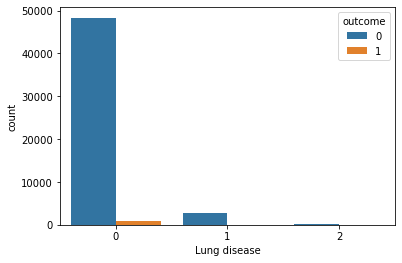

In [573]:
plotCountplot(case3_train, "Lung disease")

In [574]:
case3_train.loc[case3_train["Lung disease"]==0].outcome.value_counts()

0    48329
1      817
Name: outcome, dtype: int64

In [575]:
case3_train.loc[case3_train["Lung disease"]==1].outcome.value_counts()

0    2853
1      60
Name: outcome, dtype: int64

In [576]:
case3_train.loc[case3_train["Lung disease"]==2].outcome.value_counts()

0    98
1     2
Name: outcome, dtype: int64

### AIDS/HIV

outcome     0
AIDS/HIV    0
dtype: int64


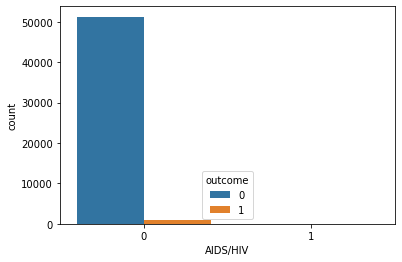

In [578]:
plotCountplot(case3_train, "AIDS/HIV")

In [579]:
case3_train.loc[case3_train["AIDS/HIV"]==0].outcome.value_counts()

0    51259
1      879
Name: outcome, dtype: int64

In [580]:
case3_train.loc[case3_train["AIDS/HIV"]==1].outcome.value_counts()

0    21
Name: outcome, dtype: int64

### Lymphoma

outcome     0
Lymphoma    0
dtype: int64


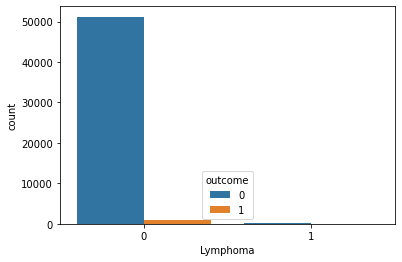

In [581]:
plotCountplot(case3_train, "Lymphoma")

In [582]:
case3_train.loc[case3_train["Lymphoma"]==0].outcome.value_counts()

0    51186
1      879
Name: outcome, dtype: int64

In [583]:
case3_train.loc[case3_train["Lymphoma"]==1].outcome.value_counts()

0    94
Name: outcome, dtype: int64

### Cancer history

outcome           0
Cancer history    0
dtype: int64


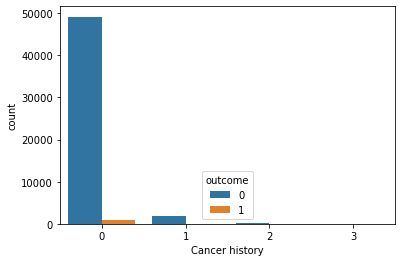

In [617]:
plotCountplot(case3_train, "Cancer history")

In [618]:
case3_train.loc[case3_train["Cancer history"]==1].outcome.value_counts()

0    1912
1      52
Name: outcome, dtype: int64

In [619]:
case3_train.loc[case3_train["Cancer history"]==2].outcome.value_counts()

0    188
1      5
Name: outcome, dtype: int64

In [620]:
case3_train.loc[case3_train["Cancer history"]==3].outcome.value_counts()

0    1
Name: outcome, dtype: int64

### Psyciatric disorder

outcome                0
Psyciatric disorder    0
dtype: int64


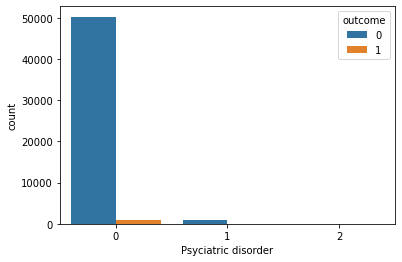

In [621]:
plotCountplot(case3_train, "Psyciatric disorder")

In [622]:
case3_train.loc[case3_train["Psyciatric disorder"]==2].outcome.value_counts()

0    55
1     4
Name: outcome, dtype: int64

In [623]:
case3_train.loc[case3_train["Psyciatric disorder"]==1].outcome.value_counts()

0    956
1     30
Name: outcome, dtype: int64

In [624]:
case3_train.loc[case3_train["Psyciatric disorder"]==0].outcome.value_counts()

0    50269
1      845
Name: outcome, dtype: int64

### Anemia

outcome    0
Anemia     0
dtype: int64


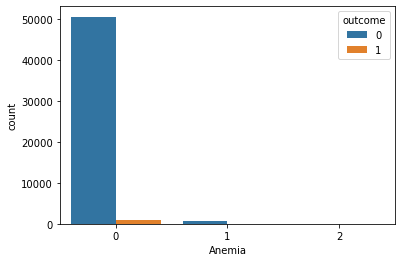

In [625]:
plotCountplot(case3_train, "Anemia")

In [627]:
case3_train.loc[case3_train["Anemia"]==1].outcome.value_counts()

0    607
1     22
Name: outcome, dtype: int64

In [628]:
case3_train.loc[case3_train["Anemia"]==2].outcome.value_counts()

0    18
1     2
Name: outcome, dtype: int64

In [629]:
case3_train.loc[case3_train["Anemia"]==0].outcome.value_counts()

0    50655
1      855
Name: outcome, dtype: int64

## Data processing

In [26]:
case3_train_final = case3_train.copy()

In [27]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,F,8.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,M,5.0,TKA,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,M,8.0,TKA,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,M,14.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,F,4.0,TKA,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,F,3.0,THA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,M,4.0,TKA,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,F,5.0,THA,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,F,5.0,THA,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
case3_train_final.isna().sum()

outcome                                        0
AGE                                           67
SEX                                           67
LOS                                           67
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             17161
OP_time_hour                               17161
ASA                                        17213
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

### 處理類別變數
- SEX
- ASA

#### Sex

In [29]:
## 拔掉94位沒有sex的，經過預先處理後(刪除重複列)，剩下67位
case3_train_final.SEX.isna().sum()

67

In [30]:
case3_train_final.dropna(axis="index", subset=["SEX"], inplace=True)

In [31]:
case3_train_final.isna().sum()

outcome                                        0
AGE                                            0
SEX                                            0
LOS                                            0
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             17134
OP_time_hour                               17134
ASA                                        17186
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

In [32]:
#轉換成數字
case3_train_final.SEX.replace({"F":0, "M":1}, inplace=True)

In [33]:
#改data feature df
case3_feature.loc[case3_feature["features name"]=="SEX", "className"] = "(0,1)"

In [34]:
case3_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


#### Joint

In [35]:
case3_train_final.Joint.replace({"TKA":0, "THA":1}, inplace=True)

In [36]:
#改data feature df
case3_feature.loc[case3_feature["features name"]=="Joint", "className"] = "(0,1)"

In [37]:
case3_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


In [38]:
case3_train_final.isna().sum()

outcome                                        0
AGE                                            0
SEX                                            0
LOS                                            0
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             17134
OP_time_hour                               17134
ASA                                        17186
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

#### ASA
- 拔掉na中outcome為0的，剩下outcome是1的補2

In [1250]:
# case3_train_final[(case3_train_final.ASA.isna()) & (case3_train_final.outcome == 0)]

In [1251]:
# ASAneedToDelIndex = case3_train_final[(case3_train_final.ASA.isna()) & (case3_train_final.outcome == 0)].index
# ASAneedToDelIndex

In [1252]:
# case3_train_final.drop(ASAneedToDelIndex, inplace=True)

In [921]:
# case3_train_final.shape

(32315, 50)

In [922]:
# case3_train_final.isna().sum()

outcome                                      0
AGE                                          0
SEX                                          0
LOS                                          0
Joint                                        0
Drain                                        0
Cemented                                     0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             353
OP_time_hour                               353
ASA                                        354
Diagnosis                                    0
Congestive Heart Failure                     0
Cardiac Arrhythmia                           0
Valvular Disease                             0
Heart disease                                0
Pulmonary Circulation Disorders              0
Peripheral Va

In [923]:
# case3_train_final.ASA.mode()

0    2.0
dtype: float64

In [924]:
##剩下的354位 通通填2
# case3_train_final.ASA.fillna(2, inplace=True)

In [925]:
# case3_train_final.isna().sum()

outcome                                      0
AGE                                          0
SEX                                          0
LOS                                          0
Joint                                        0
Drain                                        0
Cemented                                     0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             353
OP_time_hour                               353
ASA                                          0
Diagnosis                                    0
Congestive Heart Failure                     0
Cardiac Arrhythmia                           0
Valvular Disease                             0
Heart disease                                0
Pulmonary Circulation Disorders              0
Peripheral Va

In [1384]:
# ASANA_df = pd.DataFrame(case3_train_final.ASA.isna())
# ASANA_df.columns=["ASANA"]


# case3_train_final = pd.concat([case3_train_final,ASANA_df], axis=1)

In [1385]:
# case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder,ASANA
0,1,59.0,0,8.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,True
1,1,69.0,1,5.0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,False
2,1,80.0,1,8.0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,True
3,1,66.0,1,14.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,False
4,1,52.0,0,4.0,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
52155,0,78.0,1,4.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,False
52156,0,73.0,0,5.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,False
52157,0,74.0,0,5.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


In [1386]:
# case3_train_final.ASA.fillna(2, inplace=True)

In [21]:
# case3_train_final.ASA = case3_train_final.ASA.astype("int")

In [1388]:
# case3_train_final.ASA

0        2
1        3
2        2
3        2
4        2
        ..
52154    3
52155    3
52156    2
52157    2
52158    3
Name: ASA, Length: 52065, dtype: int64

In [22]:
# case3_train_final.ASA.unique()

NameError: name 'case3_train_final' is not defined

In [23]:
# case3_train_final.isna().sum()

NameError: name 'case3_train_final' is not defined

#### case3Task5 

In [39]:
case3_train_final.shape

(49074, 50)

In [40]:
case3_train_final.isna().sum()

outcome                                        0
AGE                                            0
SEX                                            0
LOS                                            0
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             17134
OP_time_hour                               17134
ASA                                        17186
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

In [41]:
case3_train_final[case3_train_final["ASA"].isna()].outcome.value_counts()

0    16840
1      346
Name: outcome, dtype: int64

In [42]:
case3_train_final[case3_train_final["OP_time_minute"].isna()].outcome.value_counts()

0    16789
1      345
Name: outcome, dtype: int64

In [43]:
case3_train_final[(~case3_train_final["ASA"].isna()) & (case3_train_final.outcome == 1)].ASA.value_counts()

2.0    274
3.0    234
1.0     14
4.0      1
Name: ASA, dtype: int64

In [44]:
case3_train_final[(~case3_train_final["ASA"].isna()) & (case3_train_final.outcome == 0)].ASA.value_counts()

2.0    16827
3.0    13673
1.0      801
4.0       64
Name: ASA, dtype: int64

In [45]:
case3_train_final[(case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())].outcome.value_counts()



0    16789
1      345
Name: outcome, dtype: int64

In [46]:
case3_train_final.outcome.value_counts()

0    48205
1      869
Name: outcome, dtype: int64

In [47]:
###決定先將18501位(ASA==null,OP==null ,outcome==0)取50%，並將OP_time_minute放outcome==0之平均
###294位（ASA==null, OP==null, outcome==1）全要，並將OP_time_minute放outcome==1之平均
###填補通通在後面OP_time_minute做(要先去除outlier等才能算)
ASA_OP_all_na = (case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())
pick_ASA_OP_all_na_df = case3_train_final[(ASA_OP_all_na) & (case3_train_final["outcome"]==0)]
pick_ASA_OP_all_na_df_length = pick_ASA_OP_all_na_df.shape[0]
pick_ASA_OP_all_na_df_index = pick_ASA_OP_all_na_df.sample(int(pick_ASA_OP_all_na_df_length * 0.5), random_state=42).index
case3_train_final.drop(pick_ASA_OP_all_na_df_index, inplace=True)

In [48]:
case3_train_final.outcome.value_counts()

0    39811
1      869
Name: outcome, dtype: int64

In [49]:
case3_train_final[(case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())].outcome.value_counts()


0    8395
1     345
Name: outcome, dtype: int64

## 處理連續變數
- AGE
- LOS
- cci_index
- elx_index
- OP_time_minute
- OP_time_hour

In [50]:
#原狀況
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5.0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8.0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4.0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
case3_train_final.isna().sum()

outcome                                       0
AGE                                           0
SEX                                           0
LOS                                           0
Joint                                         0
Drain                                         0
Cemented                                      0
Commercial_ALBC                               0
Non_commercial_ALBC                           0
cci_index                                     0
elx_index                                     0
Blood_trans                                   0
OP_time_minute                             8740
OP_time_hour                               8740
ASA                                        8792
Diagnosis                                     0
Congestive Heart Failure                      0
Cardiac Arrhythmia                            0
Valvular Disease                              0
Heart disease                                 0
Pulmonary Circulation Disorders         

### AGE

In [930]:
#刪除SEX時，已順帶刪除AGE missing

In [20]:
#outlier先暫不處理(後來需處理)

#### case3_task5處理outlier

In [52]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5.0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8.0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4.0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
#1位會被刪除
case3_train_final[case3_train_final["AGE"]>96].outcome.value_counts()

0    1
Name: outcome, dtype: int64

In [54]:
#1534位會被刪除
case3_train_final[case3_train_final["AGE"]<36].outcome.value_counts()

0    1192
1      26
Name: outcome, dtype: int64

In [55]:
age_neet_to_del_index_1 = (case3_train_final[case3_train_final["AGE"]>96]).index
age_neet_to_del_index_1 

Int64Index([38387], dtype='int64')

In [56]:
age_neet_to_del_index_2 = (case3_train_final[case3_train_final["AGE"]<36]).index
age_neet_to_del_index_2 

Int64Index([   12,    39,    46,    64,   123,   255,   322,   352,   353,
              366,
            ...
            51785, 51794, 51831, 51938, 52030, 52069, 52085, 52088, 52126,
            52138],
           dtype='int64', length=1218)

In [57]:
case3_train_final.drop(age_neet_to_del_index_1 , axis=0, inplace=True)
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5.0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8.0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4.0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#exp13不做
case3_train_final.drop(age_neet_to_del_index_2 , axis=0, inplace=True)
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5.0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8.0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4.0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5.0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### LOS（可再改用最大值替代outlier）

In [760]:
#刪除SEX時，已順帶刪除LOS missing

In [761]:
#以下處理LOS outlier

In [513]:
#共632位會被刪除
case3_train_final[case3_train_final["LOS"]>11.5].outcome.value_counts()

0    789
1     80
Name: outcome, dtype: int64

In [514]:
LOS_neet_to_del_index = (case3_train_final[case3_train_final["LOS"]>11.5]).index

In [515]:
case3_train_final.drop(LOS_neet_to_del_index, axis=0, inplace=True)

In [59]:
case3_train_final.LOS = case3_train_final.LOS.astype("int")

In [60]:
case3_train_final.LOS

0         8
1         5
2         8
3        14
4         4
         ..
52154     3
52155     4
52156     5
52157     5
52158     4
Name: LOS, Length: 39461, dtype: int64

In [61]:
case3_train_final.LOS.unique()

array([ 8,  5, 14,  4,  6, 34,  3, 11,  7, 21, 39,  9, 17, 19,  2, 46, 13,
       15, 16, 12, 10, 38, 27, 50, 33, 40, 18, 37, 23, 26, 20, 22, 36, 32,
       44, 30, 28, 31, 49, 25, 72, 29, 47, 51, 55, 58, 35, 61, 24, 42, 41,
       45, 62, 59, 67,  1, 65])

In [62]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### cci_index

In [1205]:
#>2之ouotlier都變3

In [520]:
case3_train_final[case3_train_final["cci_index"]>2].outcome.value_counts()

0    3561
1     104
Name: outcome, dtype: int64

In [521]:
cci_neet_to_change_index = (case3_train_final[case3_train_final["cci_index"]>2]).index
cci_neet_to_change_index

Int64Index([    8,    13,    17,    22,    28,    45,    80,    99,   104,
              105,
            ...
            51891, 51905, 51922, 51930, 52013, 52031, 52037, 52058, 52071,
            52099],
           dtype='int64', length=3665)

In [522]:
#替換成3
case3_train_final.loc[(case3_train_final["cci_index"]>2), "cci_index"] = 3

In [523]:
case3_train_final[case3_train_final["cci_index"]>2].cci_index

8        3
13       3
17       3
22       3
28       3
        ..
52031    3
52037    3
52058    3
52071    3
52099    3
Name: cci_index, Length: 3665, dtype: int64

### elx_index

In [1211]:
#>5之ouotlier都變6

In [524]:
case3_train_final[case3_train_final["elx_index"]>5].outcome.value_counts()

0    571
1     22
Name: outcome, dtype: int64

In [525]:
elx_neet_to_change_index = (case3_train_final[case3_train_final["elx_index"]>5]).index
elx_neet_to_change_index

Int64Index([  126,   147,   162,   191,   201,   224,   228,   318,   359,
              367,
            ...
            51294, 51510, 51728, 51777, 51779, 51786, 51891, 51905, 51922,
            52058],
           dtype='int64', length=593)

In [526]:
#替換成6
case3_train_final.loc[(case3_train_final["elx_index"]>5), "elx_index"] = 6

In [527]:
case3_train_final[case3_train_final["elx_index"]>5].elx_index

126      6
147      6
162      6
191      6
201      6
        ..
51786    6
51891    6
51905    6
51922    6
52058    6
Name: elx_index, Length: 593, dtype: int64

### OP_time_minute

In [1215]:
#del >229, del<21

In [63]:
case3_train_final[case3_train_final["OP_time_minute"]>229].outcome.value_counts()

0    432
1     19
Name: outcome, dtype: int64

In [64]:
OPtime_neet_to_change_index = (case3_train_final[case3_train_final["OP_time_minute"]>229]).index
OPtime_neet_to_change_index

Int64Index([   43,    59,    61,    84,   241,   242,   308,   341,   351,
              369,
            ...
            50290, 50418, 50585, 51077, 51168, 51592, 51680, 51703, 51839,
            51851],
           dtype='int64', length=451)

In [65]:
case3_train_final.drop(OPtime_neet_to_change_index, axis=0, inplace=True)

In [66]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
OPtime21_neet_to_change_index = (case3_train_final[case3_train_final["OP_time_minute"]<21]).index
OPtime21_neet_to_change_index

Int64Index([4195, 8845, 24640, 44822, 47819], dtype='int64')

In [68]:
case3_train_final.drop(OPtime21_neet_to_change_index, axis=0, inplace=True)

In [69]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
case3_train_final.OP_time_minute.isna().sum()

8416

In [71]:
case3_train_final[case3_train_final.OP_time_minute.isna()].outcome.value_counts()

0    8085
1     331
Name: outcome, dtype: int64

In [846]:
# case3_train_final.dropna(subset=["OP_time_minute"], inplace=True)

In [847]:
# case3_train_final["OP_time_minute"]

1        127.0
5        189.0
8        157.0
9        135.0
11       156.0
         ...  
52154     56.0
52155    161.0
52156    149.0
52157    189.0
52158    144.0
Name: OP_time_minute, Length: 30930, dtype: float64

In [72]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1226]:
##後來改填入op平均(去除outlier後)，普通ASA為２時的op minute

In [1230]:
# case3_train_final[case3_train_final["ASA"]==2]["OP_time_minute"].mean()
#約為126

125.75403056637698

In [1285]:
# case3_train_final[case3_train_final["ASANA"]==False]["OP_time_minute"].isna().sum()

0

In [1235]:
# case3_train_final["OP_time_minute"].fillna(126, inplace=True)

In [1417]:
# case3_train_final.isna().sum()

outcome                                        0
AGE                                            0
SEX                                            0
LOS                                            0
Joint                                          0
Drain                                          0
Cemented                                       0
Commercial_ALBC                                0
Non_commercial_ALBC                            0
cci_index                                      0
elx_index                                      0
Blood_trans                                    0
OP_time_minute                             19381
OP_time_hour                               19381
ASA                                            0
Diagnosis                                      0
Congestive Heart Failure                       0
Cardiac Arrhythmia                             0
Valvular Disease                               0
Heart disease                                  0
Pulmonary Circulatio

In [1418]:
# temp = pd.DataFrame((case3_train_final.OP_time_minute.isna())&(case3_train_final.ASANA == True), columns=["ASAOP"])
# case3_train_final = pd.concat([case3_train_final, temp], axis = 1)

In [1419]:
# case3_train_final 

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder,ASANA,ASAOP
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,True,True
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,False,False
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,True,True
4,1,52.0,0,4,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,True,True
5,1,84.0,0,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,False
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,False,False
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,False,False
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,False


In [1420]:
# case3_train_final.pop("ASANA")

0         True
1        False
2         True
4         True
5        False
         ...  
52154    False
52155    False
52156    False
52157    False
52158    False
Name: ASANA, Length: 50362, dtype: bool

In [1421]:
# case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder,ASAOP
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,True
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,False
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,True
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,True
5,1,84.0,0,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,False
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,False
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


In [1422]:
# case3_train_final.replace({"ASAOP":{True:1, False:0}}, inplace=True)

In [1423]:
# case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder,ASAOP
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,1
5,1,84.0,0,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1424]:
# case3_train_final["OP_time_minute"].fillna(126, inplace=True)

In [982]:
# #OP_time_minute 補?
## case3_train_final.OP_time_minute = case3_train_final.OP_time_minute.fillna("?")

In [983]:
# #case3_train_final.OP_time_minute

0            ?
1        127.0
2            ?
4            ?
5        189.0
         ...  
52154     56.0
52155    161.0
52156    149.0
52157    189.0
52158    144.0
Name: OP_time_minute, Length: 31236, dtype: object

In [1425]:
# case3_train_final.ASAOP

0        1
1        0
2        1
4        1
5        0
        ..
52154    0
52155    0
52156    0
52157    0
52158    0
Name: ASAOP, Length: 50362, dtype: int64

In [1426]:
#改featue df
# ASAOP_new_feature_df = pd.DataFrame([["ASAOP", "int64", 0, "(0,1)"]], columns=["features name","dtypes","kind","className"])
# ASAOP_new_feature_df

,features name,dtypes,kind,className
0,ASAOP,int64,0,"(0,1)"


In [1427]:
# case3_feature = pd.concat([case3_feature, ASAOP_new_feature_df], ignore_index=True)

In [1428]:
# case3_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


#### 接續ASA (Case3Task_5)

In [ ]:
###決定先將18501位(ASA==null,OP==null ,outcome==0)取50%，並將OP_time_minute放outcome==0之平均(125)
###294位（ASA==null, OP==null, outcome==1）全要，並將OP_time_minute放outcome==1之平均(136)
###填補通通在後面OP_time_minute做(要先去除outlier等才能算)

In [73]:
case3_train_final[case3_train_final.outcome == 1]["OP_time_minute"].mean()

137.01217038539554

In [74]:
case3_train_final[case3_train_final.outcome == 0]["OP_time_minute"].mean()

125.34858452950559

In [75]:
case3_train_final[(case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())].outcome.value_counts()


0    8085
1     331
Name: outcome, dtype: int64

In [76]:
ASA_OP_all_na_after = (case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())
pick_ASA_OP_all_na_df_after = case3_train_final.loc[(ASA_OP_all_na_after) & (case3_train_final["outcome"]==0)]
pick_ASA_OP_all_na_df_after

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
881,0,79.0,0,9,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
883,0,53.0,1,7,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,0,75.0,0,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
902,0,64.0,1,8,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
904,0,55.0,1,13,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52123,0,45.0,1,9,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52135,0,76.0,0,6,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52137,0,69.0,1,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52146,0,72.0,0,7,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [77]:
case3_train_final.loc[(ASA_OP_all_na_after) & (case3_train_final["outcome"]==0), "OP_time_minute"] = case3_train_final.loc[(ASA_OP_all_na_after) & (case3_train_final["outcome"]==0), "OP_time_minute"].fillna(125)


In [78]:
case3_train_final["OP_time_minute"]

0          NaN
1        127.0
2          NaN
3        224.0
4          NaN
         ...  
52154     56.0
52155    161.0
52156    149.0
52157    189.0
52158    144.0
Name: OP_time_minute, Length: 39005, dtype: float64

In [79]:
case3_train_final[(case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())].outcome.value_counts()


1    331
Name: outcome, dtype: int64

In [80]:
pick_ASA_OP_all_na_df_after_outcome1 = case3_train_final.loc[(
    ASA_OP_all_na_after) & (case3_train_final["outcome"] == 1)]
pick_ASA_OP_all_na_df_after_outcome1

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
6,1,37.0,1,6,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,42.0,0,34,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,1,86.0,0,15,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
862,1,59.0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,1,49.0,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
871,1,59.0,0,6,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
case3_train_final.loc[(ASA_OP_all_na_after) & (case3_train_final["outcome"] == 1), "OP_time_minute"] = case3_train_final.loc[(
    ASA_OP_all_na_after) & (case3_train_final["outcome"] == 1), "OP_time_minute"].fillna(136)
#ori:136 -> 137

In [82]:
case3_train_final[(case3_train_final["ASA"].isna()) & (case3_train_final["OP_time_minute"].isna())].outcome.value_counts()


Series([], Name: outcome, dtype: int64)

In [83]:
case3_train_final[(case3_train_final["OP_time_minute"]==136)&(case3_train_final["outcome"]==1)]

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
6,1,37.0,1,6,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,42.0,0,34,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,1,86.0,0,15,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
862,1,59.0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,1,49.0,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
871,1,59.0,0,6,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
case3_train_final.shape

(39005, 50)

In [85]:
## ASA全補2
case3_train_final.ASA.fillna(2, inplace=True)

In [86]:
case3_train_final.isna().sum()

outcome                                       0
AGE                                           0
SEX                                           0
LOS                                           0
Joint                                         0
Drain                                         0
Cemented                                      0
Commercial_ALBC                               0
Non_commercial_ALBC                           0
cci_index                                     0
elx_index                                     0
Blood_trans                                   0
OP_time_minute                                0
OP_time_hour                               8416
ASA                                           0
Diagnosis                                     0
Congestive Heart Failure                      0
Cardiac Arrhythmia                            0
Valvular Disease                              0
Heart disease                                 0
Pulmonary Circulation Disorders         

### OP_time_hour

In [808]:
#del

In [87]:
case3_train_final.drop("OP_time_hour", axis=1, inplace=True)

In [88]:
case3_train_final

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#改featue df
OPtime_hour_del_index = case3_feature[case3_feature["features name"]=="OP_time_hour"].index
case3_feature.drop(OPtime_hour_del_index, inplace=True)

In [90]:
case3_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


### Check case3_train_final, case3_feature

In [91]:
case3_train_final.outcome.value_counts()

0    38181
1      824
Name: outcome, dtype: int64

In [92]:
case3_train_final.isna().sum()

outcome                                    0
AGE                                        0
SEX                                        0
LOS                                        0
Joint                                      0
Drain                                      0
Cemented                                   0
Commercial_ALBC                            0
Non_commercial_ALBC                        0
cci_index                                  0
elx_index                                  0
Blood_trans                                0
OP_time_minute                             0
ASA                                        0
Diagnosis                                  0
Congestive Heart Failure                   0
Cardiac Arrhythmia                         0
Valvular Disease                           0
Heart disease                              0
Pulmonary Circulation Disorders            0
Peripheral Vascular Disorders              0
Hypertension Uncomplicated                 0
Paralysis 

In [93]:
case3_train_final.ASA.value_counts()

2.0    24672
3.0    13619
1.0      650
4.0       64
Name: ASA, dtype: int64

## Feature selection
- 先處理類別變數、連續變數

### chi-square test

In [94]:
case3_train_final_chi = case3_train_final.copy()

In [95]:
case3_train_final_chi.isna().sum()

outcome                                    0
AGE                                        0
SEX                                        0
LOS                                        0
Joint                                      0
Drain                                      0
Cemented                                   0
Commercial_ALBC                            0
Non_commercial_ALBC                        0
cci_index                                  0
elx_index                                  0
Blood_trans                                0
OP_time_minute                             0
ASA                                        0
Diagnosis                                  0
Congestive Heart Failure                   0
Cardiac Arrhythmia                         0
Valvular Disease                           0
Heart disease                              0
Pulmonary Circulation Disorders            0
Peripheral Vascular Disorders              0
Hypertension Uncomplicated                 0
Paralysis 

In [96]:
case3_train_final_chi.shape

(39005, 49)

In [97]:
case3_feature.shape

(49, 4)

In [98]:
case3_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


In [99]:
case3_feature[case3_feature["kind"]==0]["features name"]

0                                     outcome
2                                         SEX
4                                       Joint
5                                       Drain
6                                    Cemented
7                             Commercial_ALBC
8                         Non_commercial_ALBC
11                                Blood_trans
14                                        ASA
33                                  Diagnosis
34                   Congestive Heart Failure
35                         Cardiac Arrhythmia
36                           Valvular Disease
37                              Heart disease
38            Pulmonary Circulation Disorders
39              Peripheral Vascular Disorders
40                 Hypertension Uncomplicated
41                                  Paralysis
42               Other Neurological Disorders
43                  Chronic Pulmonary Disease
44                               Lung disease
45                                

In [100]:
case3_feature[case3_feature["kind"]==0]["features name"].shape

(44,)

In [101]:
##分離類別/連續
case3_train_final_chi = case3_train_final_chi[case3_feature[case3_feature["kind"]==0]["features name"]]
case3_train_final_chi

,outcome,SEX,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,Blood_trans,ASA,Diagnosis,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,0,0,1,1,0,1,0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,1,0,0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,0,1,0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,1,0,1,0,2.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,1,2.0,2,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,0,1,0,0,0,0,0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,1,0,1,1,0,1,0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,0,1,1,0,0,0,0,2.0,3,...,0,0,0,0,0,0,0,0,0,0
52157,0,0,1,1,0,0,0,1,2.0,3,...,0,0,0,0,0,0,0,0,0,0


In [102]:
##分離x, y
case3_train_final_chi_y = case3_train_final_chi.pop("outcome")

In [103]:
case3_train_final_chi_x = case3_train_final_chi.copy()
case3_train_final_chi_x

,SEX,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,Blood_trans,ASA,Diagnosis,Congestive Heart Failure,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,0,0,1,1,0,1,0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,0,0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,1,0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,1,0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,2.0,2,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,1,0,0,0,0,0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,1,0,1,1,0,1,0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,1,1,0,0,0,0,2.0,3,0,...,0,0,0,0,0,0,0,0,0,0
52157,0,1,1,0,0,0,1,2.0,3,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
case3_train_final_chi_y

0        1
1        1
2        1
3        1
4        1
        ..
52154    0
52155    0
52156    0
52157    0
52158    0
Name: outcome, Length: 39005, dtype: int64

In [105]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# 選擇要保留的特徵數
select_k = 35

# 使用 chi2 score
selection = SelectKBest(chi2, k=select_k).fit(case3_train_final_chi_x, case3_train_final_chi_y)

# 顯示保留的欄位
# features = case3_train_final_chi_x[selection.get_support()]
# print(features)x

In [106]:
case3_train_final_chi_x.columns[selection.get_support()]

Index(['SEX', 'Joint', 'Drain', 'Cemented', 'Commercial_ALBC',
       'Non_commercial_ALBC', 'Blood_trans', 'ASA', 'Diagnosis',
       'Congestive Heart Failure', 'Valvular Disease', 'Heart disease',
       'Peripheral Vascular Disorders', 'Paralysis',
       'Chronic Pulmonary Disease', 'Lung disease', 'Diabetes',
       'Hypothyroidism', 'Renal Failure', 'Liver Disease',
       'Peptic Ulcer Disease excluding bleeding', 'Lymphoma',
       'Solid Tumor without Metastasis', 'Cancer history',
       'Rheumatoid Arthritis/collagen', 'Coagulopathy',
       'Fluid and Electrolyte Disorders', 'Blood Loss Anemia',
       'Deficiency Anemia', 'Anemia', 'Alcohol Abuse', 'Drug Abuse',
       'Psychoses', 'Depression', 'Psyciatric disorder'],
      dtype='object')

## 合併Feature

In [107]:
# chi test (categorical)
case3_train_final_categorical_features  = case3_train_final_chi_x.columns[selection.get_support()].values
case3_train_final_categorical_features

array(['SEX', 'Joint', 'Drain', 'Cemented', 'Commercial_ALBC',
       'Non_commercial_ALBC', 'Blood_trans', 'ASA', 'Diagnosis',
       'Congestive Heart Failure', 'Valvular Disease', 'Heart disease',
       'Peripheral Vascular Disorders', 'Paralysis',
       'Chronic Pulmonary Disease', 'Lung disease', 'Diabetes',
       'Hypothyroidism', 'Renal Failure', 'Liver Disease',
       'Peptic Ulcer Disease excluding bleeding', 'Lymphoma',
       'Solid Tumor without Metastasis', 'Cancer history',
       'Rheumatoid Arthritis/collagen', 'Coagulopathy',
       'Fluid and Electrolyte Disorders', 'Blood Loss Anemia',
       'Deficiency Anemia', 'Anemia', 'Alcohol Abuse', 'Drug Abuse',
       'Psychoses', 'Depression', 'Psyciatric disorder'], dtype=object)

In [108]:
#continuous (目前從feature df抓所有連續)
case3_train_final_continuous_features  = case3_feature[case3_feature["kind"]==1]["features name"].values
case3_train_final_continuous_features

array(['AGE', 'LOS', 'cci_index', 'elx_index', 'OP_time_minute'],
      dtype=object)

In [109]:
# case3_train_final_categorical_features.append(case3_train_final_continuous_features)
case3_train_final_features_selection = np.append(
    case3_train_final_categorical_features, [case3_train_final_continuous_features])

In [110]:
#加入outcome
case3_train_final_features_selection = np.insert(case3_train_final_features_selection, 0,"outcome")
#加入ASAOP
# case3_train_final_features_selection = np.insert(case3_train_final_features_selection, -1,"ASAOP")

In [111]:
#排序feature
feature_list = case3_train_final_features_selection.tolist()
result_list = list()
for featureName in case3_feature["features name"].values:
    if featureName in feature_list:
        result_list.append(featureName)
case3_train_final_features_selection_sort = np.array(result_list)

In [112]:
#更新final feature
case3_final_feature = case3_feature[case3_feature["features name"].isin(case3_train_final_features_selection_sort)]
case3_final_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


In [113]:
case3_final_feature.shape

(41, 4)

In [114]:
case3_train_final_feature_selec = case3_train_final[case3_train_final_features_selection_sort].copy()

In [115]:
case3_train_final_feature_selec.columns

Index(['outcome', 'AGE', 'SEX', 'LOS', 'Joint', 'Drain', 'Cemented',
       'Commercial_ALBC', 'Non_commercial_ALBC', 'cci_index', 'elx_index',
       'Blood_trans', 'OP_time_minute', 'ASA', 'Diagnosis',
       'Congestive Heart Failure', 'Valvular Disease', 'Heart disease',
       'Peripheral Vascular Disorders', 'Paralysis',
       'Chronic Pulmonary Disease', 'Lung disease', 'Diabetes',
       'Hypothyroidism', 'Renal Failure', 'Liver Disease',
       'Peptic Ulcer Disease excluding bleeding', 'Lymphoma',
       'Solid Tumor without Metastasis', 'Cancer history',
       'Rheumatoid Arthritis/collagen', 'Coagulopathy',
       'Fluid and Electrolyte Disorders', 'Blood Loss Anemia',
       'Deficiency Anemia', 'Anemia', 'Alcohol Abuse', 'Drug Abuse',
       'Psychoses', 'Depression', 'Psyciatric disorder'],
      dtype='object')

In [116]:
case3_train_final_feature_selec

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [775]:
# case3_train_final.OP_time_minute.replace(to_replace="?", value="9999", inplace=True)

In [1110]:
# case3_train_final.OP_time_minute

0         9999
1        127.0
2         9999
4         9999
5        189.0
         ...  
52154     56.0
52155    161.0
52156    149.0
52157    189.0
52158    144.0
Name: OP_time_minute, Length: 31236, dtype: object

## 切dataset

In [117]:
case3_final_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


In [118]:
case3_train_final_feature_selec

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,1,59.0,0,8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,69.0,1,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,80.0,1,8,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,66.0,1,14,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,52.0,0,4,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52154,0,78.0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52155,0,78.0,1,4,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
52156,0,73.0,0,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52157,0,74.0,0,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
case3_train_split, case3_val_split = train_test_split(
    case3_train_final_feature_selec, test_size=0.2, random_state=42, stratify=case3_train_final_feature_selec["outcome"])

In [120]:
case3_train_split

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
8604,0,52.0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36739,0,68.0,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10910,0,65.0,0,4,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20854,0,62.0,0,8,0,1,1,0,1,3,...,0,0,0,0,0,0,0,0,1,1
25483,0,72.0,1,7,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25391,0,43.0,1,7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24520,0,81.0,0,2,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
21051,0,73.0,0,4,1,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
16244,0,54.0,0,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
case3_val_split

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
19319,0,70.0,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17906,0,82.0,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28885,0,61.0,0,5,0,1,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
10228,0,69.0,0,5,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
28738,0,70.0,0,6,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16487,0,65.0,0,4,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7672,0,78.0,1,8,0,0,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0
47059,0,78.0,1,2,1,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
22344,0,76.0,0,3,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


## SMOTE 

In [122]:
case3_train_outcome = case3_train_split.pop("outcome")

In [123]:
case3_train_outcome

8604     0
36739    0
10910    0
20854    0
25483    0
        ..
25391    0
24520    0
21051    0
16244    0
2549     0
Name: outcome, Length: 31204, dtype: int64

In [124]:
Counter(case3_train_outcome)

Counter({0: 30545, 1: 659})

In [1078]:
int((31140*0.38)/0.62)

19085

In [125]:
# 0->31140, 1->19085
# smo_case3 = SMOTE(sampling_strategy={1:int((31467*0.45))},random_state=42)
smo_case3 = SMOTE(random_state=42)

In [126]:
case3_train_split

,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
8604,52.0,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36739,68.0,0,5,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
10910,65.0,0,4,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
20854,62.0,0,8,0,1,1,0,1,3,4,...,0,0,0,0,0,0,0,0,1,1
25483,72.0,1,7,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25391,43.0,1,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24520,81.0,0,2,0,0,1,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0
21051,73.0,0,4,1,0,0,0,0,4,4,...,0,0,0,0,0,0,0,0,0,0
16244,54.0,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
Counter(case3_train_outcome)

Counter({0: 30545, 1: 659})

In [128]:
case3_train_X_train,  case3_train_y_train = smo_case3.fit_resample(case3_train_split, case3_train_outcome)

In [129]:
Counter(case3_train_y_train)

Counter({0: 30545, 1: 30545})

In [130]:
case3_train_X_train

,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,52.000000,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,68.000000,0,5,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,65.000000,0,4,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,62.000000,0,8,0,1,1,0,1,3,4,...,0,0,0,0,0,0,0,0,1,1
4,72.000000,1,7,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61085,67.000000,0,5,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
61086,67.326719,0,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61087,75.000000,0,5,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61088,55.701744,0,5,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [131]:
case3_train_y_train

0        0
1        0
2        0
3        0
4        0
        ..
61085    1
61086    1
61087    1
61088    1
61089    1
Name: outcome, Length: 61090, dtype: int64

In [132]:
case3_train_X_train.insert(0,"outcome",case3_train_y_train)

In [133]:
case3_train_X_train

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,0,52.000000,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,68.000000,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,65.000000,0,4,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,62.000000,0,8,0,1,1,0,1,3,...,0,0,0,0,0,0,0,0,1,1
4,0,72.000000,1,7,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61085,1,67.000000,0,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
61086,1,67.326719,0,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61087,1,75.000000,0,5,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61088,1,55.701744,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Task

In [134]:
case3_final_feature

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
6,Cemented,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None


In [135]:
case3_final_feature.shape

(41, 4)

In [136]:
case3_train_X_train

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,0,52.000000,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,68.000000,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,65.000000,0,4,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,62.000000,0,8,0,1,1,0,1,3,...,0,0,0,0,0,0,0,0,1,1
4,0,72.000000,1,7,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61085,1,67.000000,0,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
61086,1,67.326719,0,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61087,1,75.000000,0,5,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61088,1,55.701744,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
case3_val_split.outcome

19319    0
17906    0
28885    0
10228    0
28738    0
        ..
16487    0
7672     0
47059    0
22344    0
17350    0
Name: outcome, Length: 7801, dtype: int64

In [138]:
case3_val_split

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
19319,0,70.0,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17906,0,82.0,0,5,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28885,0,61.0,0,5,0,1,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
10228,0,69.0,0,5,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
28738,0,70.0,0,6,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16487,0,65.0,0,4,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7672,0,78.0,1,8,0,0,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0
47059,0,78.0,1,2,1,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
22344,0,76.0,0,3,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [139]:
case3_train_X_train_shuffled=case3_train_X_train.sample(frac=1, random_state=42)
case3_train_X_train_shuffled

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
1641,0,66.000000,0,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11114,0,44.000000,0,6,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
59217,1,69.396132,0,7,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19270,0,70.000000,0,3,0,0,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0
6821,0,59.000000,0,8,0,1,1,0,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1,41.367598,1,39,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38158,1,66.338200,0,7,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
860,0,47.000000,1,7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15795,0,80.000000,0,5,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [140]:
case3_train_X_train_shuffled.AGE = case3_train_X_train_shuffled.AGE.astype("int")

In [141]:
case3_train_X_train_shuffled.OP_time_minute = case3_train_X_train_shuffled.OP_time_minute.astype("int")

In [142]:
case3_train_X_train_shuffled.ASA = case3_train_X_train_shuffled.ASA.astype("int")

In [143]:
case3_train_X_train_shuffled

,outcome,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,...,Coagulopathy,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
1641,0,66,0,5,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11114,0,44,0,6,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
59217,1,69,0,7,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19270,0,70,0,3,0,0,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0
6821,0,59,0,8,0,1,1,0,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1,41,1,39,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38158,1,66,0,7,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
860,0,47,1,7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15795,0,80,0,5,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [144]:
case3_train_y_train_shuffled = case3_train_X_train_shuffled.pop("outcome")

In [145]:
case3_y_val_split = case3_val_split.pop("outcome")

### Store to pickle

In [146]:
store2Pickle(case3_train_X_train_shuffled, "data/exp14/exp14_X_train")

store2Pickle Successful!


In [147]:
store2Pickle(case3_train_y_train_shuffled , "data/exp14/exp14_y_train")

store2Pickle Successful!


In [148]:
store2Pickle(case3_val_split , "data/exp14/exp14_X_val")

store2Pickle Successful!


In [149]:
store2Pickle(case3_y_val_split , "data/exp14/exp14_y_val")

store2Pickle Successful!


# Prepare unseen testing dataset
- 記得！ 順序不可以改變，不可以shuffle
- 記得！ 不能刪outlier，可改最大最小值
- 大致動作:
    - 挑feature (照最後chi-k＋連續值項目)
    - 處理outlier
    - 補missing value
- check datatype!

In [997]:
#不能刪重複值

## Load test data

In [1095]:
raw_test_data = pd.read_csv("data/ts.csv")

In [1096]:
raw_test_data

,AGE,SEX,LOS,Joint,Drain,Cemented,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,81.0,M,3.0,TKA,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34.0,F,3.0,THA,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,54.0,F,6.0,TKA,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,84.0,F,25.0,TKA,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,73.0,F,4.0,TKA,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,64.0,F,2.0,THA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
486,63.0,F,4.0,TKA,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
487,42.0,M,6.0,THA,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,59.0,F,5.0,TKA,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1101]:
final_feature_for_test = case3_final_feature.copy()
final_feature_for_test

,features name,dtypes,kind,className
0,outcome,int64,0,"(0,1)"
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None
10,elx_index,int64,1,None


In [1106]:
final_feature_outcome_index = final_feature_for_test[final_feature_for_test["features name"] == "outcome"].index
final_feature_outcome_index

Int64Index([0], dtype='int64')

In [1109]:
final_feature_for_test.drop(final_feature_outcome_index, inplace=True)

In [1111]:
final_feature_for_test["features name"].values

array(['AGE', 'SEX', 'LOS', 'Joint', 'Drain', 'Commercial_ALBC',
       'Non_commercial_ALBC', 'cci_index', 'elx_index', 'Blood_trans',
       'OP_time_minute', 'ASA', 'Diagnosis', 'Congestive Heart Failure',
       'Valvular Disease', 'Heart disease',
       'Peripheral Vascular Disorders', 'Hypertension Uncomplicated',
       'Paralysis', 'Lung disease', 'Diabetes', 'Hypothyroidism',
       'Renal Failure', 'Liver Disease',
       'Peptic Ulcer Disease excluding bleeding', 'Lymphoma',
       'Solid Tumor without Metastasis', 'Cancer history',
       'Rheumatoid Arthritis/collagen', 'Coagulopathy', 'Weight Loss',
       'Fluid and Electrolyte Disorders', 'Blood Loss Anemia',
       'Deficiency Anemia', 'Anemia', 'Alcohol Abuse', 'Drug Abuse',
       'Psychoses', 'Depression', 'Psyciatric disorder'], dtype=object)

In [1114]:
raw_test_data = raw_test_data[final_feature_for_test["features name"].values]
raw_test_data

,AGE,SEX,LOS,Joint,Drain,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,Blood_trans,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,81.0,M,3.0,TKA,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34.0,F,3.0,THA,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
2,54.0,F,6.0,TKA,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,84.0,F,25.0,TKA,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,73.0,F,4.0,TKA,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,64.0,F,2.0,THA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
486,63.0,F,4.0,TKA,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
487,42.0,M,6.0,THA,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,59.0,F,5.0,TKA,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### check missing 

In [1115]:
raw_test_data.isna().sum()

AGE                                          1
SEX                                          1
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                        180
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1118]:
raw_test_data[raw_test_data.AGE.isna()]

,AGE,SEX,LOS,Joint,Drain,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,Blood_trans,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
172,NaN,NaN,NaN,TKA,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## AGE
- 補值
- outlier (>96, <36)
- 轉型態

In [1117]:
raw_test_data.AGE.mode()

0    70.0
dtype: float64

In [1122]:
raw_test_data.AGE.fillna(70, inplace=True)

In [1132]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          1
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                        180
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1125]:
raw_test_data[raw_test_data.AGE>96]

,AGE,SEX,LOS,Joint,Drain,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,Blood_trans,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder


In [1130]:
raw_test_data.loc[(raw_test_data.AGE<36),"AGE"] = 36

In [1131]:
raw_test_data.loc[(raw_test_data.AGE<36),"AGE"]

Series([], Name: AGE, dtype: float64)

In [1133]:
raw_test_data.AGE

0      81.0
1      36.0
2      54.0
3      84.0
4      73.0
       ... 
485    64.0
486    63.0
487    42.0
488    59.0
489    75.0
Name: AGE, Length: 490, dtype: float64

In [1136]:
raw_test_data.AGE = raw_test_data.AGE.astype("int")

In [1137]:
raw_test_data.AGE

0      81
1      36
2      54
3      84
4      73
       ..
485    64
486    63
487    42
488    59
489    75
Name: AGE, Length: 490, dtype: int64

## SEX
- 補值
- 轉成數字

In [1138]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          1
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                        180
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1139]:
raw_test_data.SEX.mode()

0    F
dtype: object

In [1142]:
raw_test_data.SEX.fillna("F", inplace=True)

In [1145]:
raw_test_data.SEX

0      M
1      F
2      F
3      F
4      F
      ..
485    F
486    F
487    M
488    F
489    F
Name: SEX, Length: 490, dtype: object

In [1143]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                        180
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1146]:
#轉換成數字
raw_test_data.SEX.replace({"F":0, "M":1}, inplace=True)

In [1147]:
raw_test_data.SEX

0      1
1      0
2      0
3      0
4      0
      ..
485    0
486    0
487    1
488    0
489    0
Name: SEX, Length: 490, dtype: int64

## Joint
- 轉成數字

In [1148]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                        180
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1150]:
raw_test_data.Joint

0      TKA
1      THA
2      TKA
3      TKA
4      TKA
      ... 
485    THA
486    TKA
487    THA
488    TKA
489    THA
Name: Joint, Length: 490, dtype: object

In [1151]:
raw_test_data.Joint.replace({"TKA":0, "THA":1}, inplace=True)

In [1152]:
raw_test_data.Joint

0      0
1      1
2      0
3      0
4      0
      ..
485    1
486    0
487    1
488    0
489    1
Name: Joint, Length: 490, dtype: int64

## ASA
- 補值
- 轉型態

In [1154]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                        180
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1153]:
raw_test_data.ASA

0      3.0
1      3.0
2      2.0
3      2.0
4      3.0
      ... 
485    2.0
486    3.0
487    3.0
488    2.0
489    3.0
Name: ASA, Length: 490, dtype: float64

In [1158]:
raw_test_data.ASA.fillna(2, inplace=True)

In [1160]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                          0
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1163]:
raw_test_data.ASA = raw_test_data.ASA.astype("int")

In [1164]:
raw_test_data.ASA

0      3
1      3
2      2
3      2
4      3
      ..
485    2
486    3
487    3
488    2
489    3
Name: ASA, Length: 490, dtype: int64

## LOS
- 補值
- outlier(>11.5)
- 轉型態

In [1165]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          1
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                          0
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1166]:
raw_test_data.LOS.mean()

5.748466257668712

In [1169]:
raw_test_data.LOS.fillna(6, inplace=True)

In [1170]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          0
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                          0
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1174]:
raw_test_data.loc[(raw_test_data.LOS>11.5),"LOS"]  = 11

In [1175]:
raw_test_data.loc[(raw_test_data.LOS>11.5),"LOS"]

Series([], Name: LOS, dtype: float64)

In [1176]:
raw_test_data.LOS = raw_test_data.LOS.astype("int")

In [1177]:
raw_test_data.LOS

0       3
1       3
2       6
3      11
4       4
       ..
485     2
486     4
487     6
488     5
489     5
Name: LOS, Length: 490, dtype: int64

## cci_index
- outlier(>2 -> 3)

In [1179]:
raw_test_data.loc[(raw_test_data.cci_index>2),"cci_index"]  = 3

In [1180]:
raw_test_data.cci_index

0      0
1      1
2      0
3      1
4      0
      ..
485    0
486    0
487    0
488    0
489    0
Name: cci_index, Length: 490, dtype: int64

## elx_index
- outlier (>5 -> 6)

In [1182]:
raw_test_data.loc[(raw_test_data.elx_index>5),"elx_index"]  = 6

In [1183]:
raw_test_data.elx_index

0      0
1      2
2      1
3      1
4      0
      ..
485    0
486    1
487    0
488    0
489    0
Name: elx_index, Length: 490, dtype: int64

## OP_time_minute
- outlier (>229, <21)
- 補值

In [1185]:
raw_test_data.loc[(raw_test_data.OP_time_minute>229),"OP_time_minute"]  = 229

In [1186]:
raw_test_data.loc[(raw_test_data.OP_time_minute<21),"OP_time_minute"] 

Series([], Name: OP_time_minute, dtype: float64)

In [1187]:
raw_test_data.OP_time_minute.mean()

132.46129032258065

In [1189]:
raw_test_data.isna().sum()

AGE                                          0
SEX                                          0
LOS                                          0
Joint                                        0
Drain                                        0
Commercial_ALBC                              0
Non_commercial_ALBC                          0
cci_index                                    0
elx_index                                    0
Blood_trans                                  0
OP_time_minute                             180
ASA                                          0
Diagnosis                                    0
Congestive Heart Failure                     0
Valvular Disease                             0
Heart disease                                0
Peripheral Vascular Disorders                0
Hypertension Uncomplicated                   0
Paralysis                                    0
Lung disease                                 0
Diabetes                                     0
Hypothyroidis

In [1192]:
raw_test_data.OP_time_minute.fillna(132, inplace=True)

In [1193]:
raw_test_data.isna().sum()

AGE                                        0
SEX                                        0
LOS                                        0
Joint                                      0
Drain                                      0
Commercial_ALBC                            0
Non_commercial_ALBC                        0
cci_index                                  0
elx_index                                  0
Blood_trans                                0
OP_time_minute                             0
ASA                                        0
Diagnosis                                  0
Congestive Heart Failure                   0
Valvular Disease                           0
Heart disease                              0
Peripheral Vascular Disorders              0
Hypertension Uncomplicated                 0
Paralysis                                  0
Lung disease                               0
Diabetes                                   0
Hypothyroidism                             0
Renal Fail

In [1194]:
raw_test_data.OP_time_minute

0      104.0
1       93.0
2      152.0
3      152.0
4       70.0
       ...  
485     60.0
486    105.0
487     76.0
488    103.0
489    153.0
Name: OP_time_minute, Length: 490, dtype: float64

## final check

In [1195]:
raw_test_data

,AGE,SEX,LOS,Joint,Drain,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,Blood_trans,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
0,81,1,3,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,3,1,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
2,54,0,6,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,84,0,11,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,73,0,4,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,64,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
486,63,0,4,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
487,42,1,6,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,59,0,5,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1196]:
final_feature_for_test

,features name,dtypes,kind,className
1,AGE,float64,1,None
2,SEX,object,0,"(0,1)"
3,LOS,float64,1,None
4,Joint,object,0,"(0,1)"
5,Drain,int64,0,"(0,1)"
7,Commercial_ALBC,int64,0,"(0,1)"
8,Non_commercial_ALBC,int64,0,"(0,1)"
9,cci_index,int64,1,None
10,elx_index,int64,1,None
11,Blood_trans,int64,0,"(0,1)"


In [1197]:
final_feature_for_test.shape

(40, 4)

In [1213]:
case3_train_X_train_shuffled.ASA

12660    2.0
15988    3.0
31224    2.0
10398    1.0
41231    2.0
        ... 
6265     3.0
11284    2.0
38158    3.0
860      3.0
15795    3.0
Name: ASA, Length: 43417, dtype: float64

# Prepare final data

In [1237]:
case3_train_X_train_shuffled

,outcome,AGE,SEX,LOS,Joint,Drain,Commercial_ALBC,Non_commercial_ALBC,cci_index,elx_index,...,Weight Loss,Fluid and Electrolyte Disorders,Blood Loss Anemia,Deficiency Anemia,Anemia,Alcohol Abuse,Drug Abuse,Psychoses,Depression,Psyciatric disorder
12660,1,60,1,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15988,0,75,0,7,0,1,0,1,2,3,...,0,0,0,0,0,0,0,0,0,0
31224,1,50,0,5,0,1,0,0,3,2,...,0,0,0,0,0,0,0,0,0,0
10398,0,39,1,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41231,1,55,1,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0,80,1,4,0,1,0,1,3,4,...,0,0,0,0,0,0,0,0,0,0
11284,0,73,0,4,0,1,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
38158,1,78,1,4,0,1,0,1,2,1,...,0,0,0,0,0,0,0,0,0,0
860,0,64,0,5,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1216]:
store2CSV(case3_train_X_train_shuffled, "final_training_dataset")

Caution: File existed!
Do you want to cover it?(Y/others)Y
store2CSV Successful!


In [1217]:
store2Pickle(case3_train_X_train_shuffled, "final_training_dataset")

Caution: File existed!
Do you want to cover it?(Y/others)Y
store2Pickle Successful!


In [1210]:
store2CSV(case3_val_split, "final_validation_dataset")

Caution: File existed!
Do you want to cover it?(Y/others)Y
store2CSV Successful!


In [1211]:
store2Pickle(case3_val_split, "final_validation_dataset")

Caution: File existed!
Do you want to cover it?(Y/others)Y
store2Pickle Successful!


In [1198]:
## final testing(unlabel) dataset
store2CSV(raw_test_data, "final_testing_dataset")

store2CSV Successful!


In [1199]:
store2Pickle(raw_test_data, "final_testing_dataset")

store2Pickle Successful!


In [1200]:
store2CSV(final_feature_for_test, "final_feature_for_test")

store2CSV Successful!


In [1201]:
store2Pickle(final_feature_for_test, "final_feature_for_test")

store2Pickle Successful!


# Combine missing value counts into feature

In [589]:
reArray = list()
for i in range(len(case3_train)):
    reArray.append(case3_train.iloc[i].isna().sum())

In [593]:
reArray_np = np.array(reArray)

In [594]:
np.argmax(reArray_np)

91

In [599]:
reArray_df = pd.DataFrame(reArray)

In [603]:
reArray_df.value_counts()

0    31961
3    20092
6       54
1       52
dtype: int64

In [609]:
reArray_df[0].unique()

array([3, 0, 6, 1])

In [606]:
combine = pd.concat([reArray_df, case3_train["outcome"]], axis = 1)

In [607]:
combine

,0,outcome
0,3,1
1,0,1
2,3,1
3,0,1
4,3,1
...,...,...
52154,0,0
52155,0,0
52156,0,0
52157,0,0


In [610]:
combine[combine[0]==0].value_counts()

0  outcome
0  0          31438
   1            523
dtype: int64

In [611]:
combine[combine[0]==1].value_counts()

0  outcome
1  0          51
   1           1
dtype: int64

In [612]:
combine[combine[0]==3].value_counts()

0  outcome
3  0          19738
   1            354
dtype: int64

In [613]:
combine[combine[0]==6].value_counts()

0  outcome
6  0          53
   1           1
dtype: int64

In [616]:
combine[(combine[0]==6) | (combine[0]==1)].outcome.value_counts()

0    104
1      2
Name: outcome, dtype: int64

In [595]:
case3_train.iloc[91].outcome

1